In [1]:
%pip install mosaicml
%pip install tensorflow
%pip install imbalanced-learn
%pip install torchcontrib
%pip install torchsummary

  Obtaining dependency information for mosaicml from https://files.pythonhosted.org/packages/f6/db/35f413cd624b931c7f624a9e4dce320787d90b7a47a4011ba8acb9af715f/mosaicml-0.16.0-py3-none-any.whl.metadata
  Obtaining dependency information for torchmetrics<1.1,>=0.10.0 from https://files.pythonhosted.org/packages/67/90/9ac94af10cd1777859a92be1e8186325490654930e871f8bb219cc342868/torchmetrics-1.0.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 12.8 MB/s eta 0:00:00
  Obtaining dependency information for mosaicml-cli<0.6,>=0.4.12 from https://files.pythonhosted.org/packages/c8/20/802d8e1ba87713ff3f3bf2971b7282fbd5f7179ff8df430568d473a700ce/mosaicml_cli-0.5.7-py3-none-any.whl.metadata
  Obtaining dependency information for argcomplete>=2.0.0 from https://files.pythonhosted.org/packages/4f/ef/8b604222ba5e5190e25851aa3a5b754f2002361dc62a258a8e9f13e866f4/argcomplete-3.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 

In [1]:
from pathlib  import Path
import pathlib
dataset_path='./data/ham10000'

In [25]:
from numpy.random import seed
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import torch
import torchvision
import torch.nn.functional as F

from composer.models import ComposerModel
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np
from torchvision import transforms, datasets

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import time
import torchmetrics

import torch.optim as optim
from composer import Trainer
import composer
from composer.algorithms import BlurPool
from composer.loggers import InMemoryLogger

import matplotlib.pyplot as plt
import numpy as np


import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
from torchvision.transforms.functional import InterpolationMode

from torchvision.models.inception import InceptionOutputs
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchsummary import summary
from composer.core import Evaluator



In [3]:
base_dir='./data/ham10000'
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Test')

In [4]:
df_data=pd.read_csv(base_dir+'/HAM10000_metadata')

In [5]:
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head(100)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000001,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
95,HAM_0000132,1,1,1,1,1,1,1
96,HAM_0000133,1,1,1,1,1,1,1
97,HAM_0000134,1,1,1,1,1,1,1
98,HAM_0000137,1,1,1,1,1,1,1


In [6]:
from torchvision import transforms, datasets
from torchvision.transforms import InterpolationMode
import torch.nn.functional as F
import torch
import torch.nn as nn

base_dir = "./data/ham10000"  # Provide your directory path

def transform_images(image_size, crop_size=None):
    train_path = base_dir + '/Train/'
    valid_path = base_dir + '/Test/'

    train_transforms = transforms.Compose([
        transforms.Resize(image_size, interpolation=InterpolationMode.BILINEAR),
        transforms.CenterCrop(crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    valid_transforms = transforms.Compose([
        transforms.Resize(image_size, interpolation=InterpolationMode.BILINEAR),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
    valid_dataset = datasets.ImageFolder(root=valid_path, transform=valid_transforms)

    train_batch_size = 10
    val_batch_size = 10

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=val_batch_size, shuffle=False)
    test_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False)

    return train_dataloader, valid_dataloader, test_dataloader


In [7]:

train_loader, eval_dataloader, test_loader =transform_images((300,400),(300,400))

In [8]:
def swish(x):
    return x * torch.sigmoid(x)

In [9]:
class DeepComposerCNN(ComposerModel):
    
    def __init__(self):
        super(DeepComposerCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(128, 256, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.fc_dim = self.get_flattened_size()  # Adjusted based on the architecture
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.fc_dim, 512)
        self.fc_bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.fc_bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, 7)
        
    def forward(self, inputs):
        x, _ = inputs 
        x = swish(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = swish(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = swish(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = swish(self.fc_bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = swish(self.fc_bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = self.fc3(x)
        return x

    def loss(self, outputs, inputs):
        _, targets = inputs # Unpack the tuple
        return F.cross_entropy(outputs, targets)
    
    def get_flattened_size(self):
        x = torch.randn(1, 3, 300, 400)  # Dummy input
        x = self.pool1(swish(self.bn1(self.conv1(x))))
        x = self.pool2(swish(self.bn2(self.conv2(x))))
        x = self.pool3(swish(self.bn3(self.conv3(x))))
        return x.view(-1).shape[0]


In [10]:
# Instantiate the model
model = DeepComposerCNN()

# Calculate number of parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params, trainable_params


(242990087, 242990087)

In [11]:
total_layers = sum(1 for _ in model.modules())
total_layers

17

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
model = model.cuda()

# Use the summary function with the correct input size
summary(model, input_size=(10,3, 300, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 400]           1,792
       BatchNorm2d-2         [-1, 64, 300, 400]             128
         MaxPool2d-3         [-1, 64, 150, 200]               0
            Conv2d-4        [-1, 128, 150, 200]          73,856
       BatchNorm2d-5        [-1, 128, 150, 200]             256
         MaxPool2d-6         [-1, 128, 75, 100]               0
            Conv2d-7         [-1, 256, 75, 100]         295,168
       BatchNorm2d-8         [-1, 256, 75, 100]             512
         MaxPool2d-9          [-1, 256, 37, 50]               0
           Linear-10                  [-1, 512]     242,483,712
      BatchNorm1d-11                  [-1, 512]           1,024
          Dropout-12                  [-1, 512]               0
           Linear-13                  [-1, 256]         131,328
      BatchNorm1d-14                  [

In [13]:
def requirementsForModelTraining(model):
    blurpool = BlurPool(
    replace_convs=True, # Blur before convs
    replace_maxpools=True, # Blur before max-pools
    blur_first=True # Blur before conv/max-pool)
    )
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    algorithms=[blurpool]
    return algorithms, optimizer

In [14]:
import composer.functional as cf
from composer.callbacks import ExportForInferenceCallback
# change to 'torchscript' for exporting to torchscript format
save_format = 'onnx'
model_save_path = os.path.join("./models", '202kPModel.onnx')
export_callback = ExportForInferenceCallback(save_format=save_format, save_path=model_save_path)

In [26]:
evaluator = Evaluator(
    dataloader = eval_dataloader,
    label = "eval",
    metric_names = ['MulticlassAccuracy']
)

In [15]:
from composer.callbacks import EarlyStopper

early_stopper = EarlyStopper(monitor="Accuracy", dataloader_label="eval",patience=1)

In [30]:
trainer.close()

In [31]:
from composer.trainer import Trainer
from composer.loggers import InMemoryLogger

logger = InMemoryLogger()
# Assuming the CustomModelComposer class and other necessary code from previous steps are already executed

# Create an instance of the model
model=DeepComposerCNN()
algorithms, optimizer,  = requirementsForModelTraining(model)

trainer = Trainer(
    model=model,
    optimizers=optimizer,
    train_dataloader=train_loader,
    eval_dataloader=eval_dataloader,
    max_duration='20ep',
    loggers=logger,
    algorithms=algorithms,
    save_folder="checkpoints",
    save_filename="cmbpCB2008{epoch}.pt",
    save_interval="2ep",
    callbacks=[early_stopper, export_callback]
)




In [32]:
start_time = time.perf_counter()
trainer.fit() # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

******************************
Config:
blurpool/num_blurconv_layers: 0
blurpool/num_blurpool_layers: 3
enabled_algorithms/BlurPool: true
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 3525880457

******************************


train          Epoch   0:    0%|| 0/3889 [00:00<?, ?ba/s]         

OutOfMemoryError: CUDA out of memory. Tried to allocate 926.00 MiB (GPU 0; 14.75 GiB total capacity; 12.79 GiB already allocated; 888.81 MiB free; 13.72 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [17]:
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
num_of_classes=7
def evaluate_model(model):  
    model.eval()
    accuracy_metric = torchmetrics.classification.MulticlassAccuracy(num_classes=num_of_classes, average='micro')
    true_labels = []
    predicted_labels = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in eval_dataloader:
            # Move data to the same device as the model (CPU or GPU)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)
            inputs, targets = inputs.to(device), targets.to(device)

            # Perform the forward pass and get the outputs
            outputs = model(inputs)

            # Get the predicted class by finding the index with the highest score
            _, predicted = torch.max(outputs.data, 1)

            # Accumulate the true labels and predicted labels for each batch
            true_labels.extend(targets.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
    # Convert the lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Create the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Print the results
    accuracy = 100 * correct / total
    print(f"Accuracy on the evaluation dataset: {accuracy:.2f}%")
    print("\n")

    # Calculate precision, recall, and F1 score for each class
    TP = np.diag(conf_matrix)
    FP = np.sum(conf_matrix, axis=0) - TP
    FN = np.sum(conf_matrix, axis=1) - TP
    TN = np.sum(conf_matrix) - (TP + FP + FN)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score)


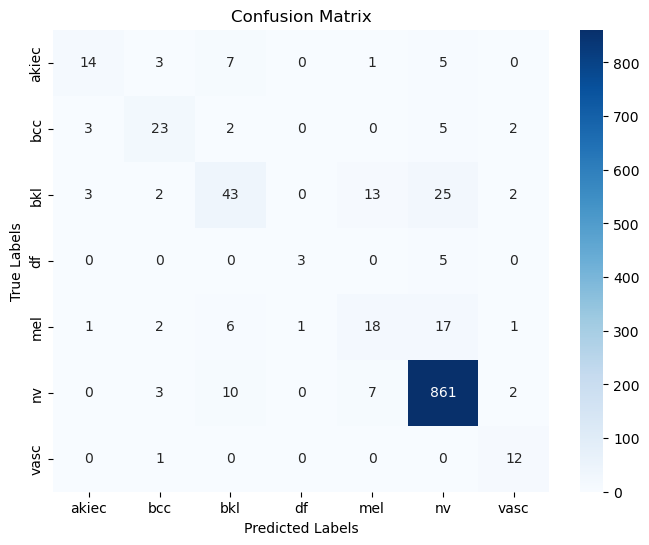

Accuracy on the evaluation dataset: 88.30%


Precision: [0.66666667 0.67647059 0.63235294 0.75       0.46153846 0.9379085
 0.63157895]
Recall: [0.46666667 0.65714286 0.48863636 0.375      0.39130435 0.97508494
 0.92307692]
F1 Score: [0.54901961 0.66666667 0.55128205 0.5        0.42352941 0.95613548
 0.75      ]


In [18]:
evaluate_model(model)

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
        
    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return F.relu(out + self.residual(identity))

class CustomCNN(ComposerModel):
    
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        # Encoder
        self.res1 = ResBlock(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.res2 = ResBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.res3 = ResBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        # Decoder
        self.upconv2 = nn.Upsample(size=(295, 195), mode='bilinear', align_corners=True)
        self.res4 = ResBlock(384, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.res5 = ResBlock(128, 64)
        
        # Final classification layer
        self.classifier = nn.Conv2d(64, 7, kernel_size=1)  # 7 classes
        
    def forward(self, x):
        # Encoder
        if isinstance(x, tuple):
            x, _ = x
        x1 = self.res1(x)
        x2 = self.pool1(x1)

        x2 = self.res2(x2)
        x3 = self.pool2(x2)

        x3 = self.res3(x3)
        x = self.pool3(x3)

        # Decoder
        # Use F.interpolate to dynamically adjust the size based on x2
        x = F.interpolate(x, size=(x2.size(2), x2.size(3)), mode='bilinear', align_corners=True)

        x = torch.cat([x, x2], dim=1)  # Skip connection
        x = self.res4(x)

        x = self.upconv1(x)
        x = torch.cat([x, x1], dim=1)  # Skip connection

        x = self.res5(x)
        x = self.classifier(x)

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return x


    def loss(self, outputs, inputs):
        _, targets = inputs # Unpack the tuple
        return F.cross_entropy(outputs, targets)


In [31]:

train_loader, eval_dataloader, test_loader =transform_images((450,300),(450,300))

In [32]:
from composer.trainer import Trainer
from composer.loggers import InMemoryLogger

logger = InMemoryLogger()
# Assuming the CustomModelComposer class and other necessary code from previous steps are already executed

# Create an instance of the model
customResBlockModel=CustomCNN()
algorithms, optimizer,  = requirementsForModelTraining(customResBlockModel)

trainer = Trainer(
    model=customResBlockModel,
    optimizers=optimizer,
    train_dataloader=train_loader,
    eval_dataloader=eval_dataloader,
    max_duration='5ep',
    loggers=logger
)




In [ ]:
start_time = time.perf_counter()
trainer.fit() # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.optim import Adam
from composer.trainer import Trainer
from composer.loggers import InMemoryLogger
import matplotlib.pyplot as plt

class CustomModel(ComposerModel):
    def __init__(self, base_arch, hidden_layers, num_classes):
        super(CustomModel, self).__init__()
        
        if base_arch == 'DenseNet121':
            self.base_arch = models.densenet121(pretrained=True).features
        elif base_arch == 'DenseNet201':
            self.base_arch = models.densenet201(pretrained=True).features
        
        prev_layer_size = 1024  # Output size of the base architecture
        
        layers = []
        for layer_size in hidden_layers:
            layers.extend([
                nn.Linear(prev_layer_size, layer_size),
                nn.ReLU(),
                nn.BatchNorm1d(layer_size),
                nn.Dropout(0.36)
            ])
            prev_layer_size = layer_size
        
        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_layer_size, num_classes)
        
    def forward(self, x):
        x = self.base_arch(x)
        x = torch.flatten(x, 1)  # Flatten
        
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

class Tuner(object):
    def __init__(self, train_loader, eval_dataloader, test_loader, architecture, hidden_layers, classes, epochs, batch_size):
        self.base_arch = architecture
        self.hidden_layers = hidden_layers
        self.classes = classes
        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size

        self.model = CustomModel(self.base_arch, self.hidden_layers, self.classes)
        self.train_loader = train_loader
        self.eval_dataloader = eval_dataloader
        self.test_loader = test_loader

        self.logger = InMemoryLogger()
        self.trainer = Trainer(
            model=self.model,
            optimizers=Adam(self.model.parameters(), lr=0.001),
            train_dataloader=self.train_loader,
            eval_dataloader=self.eval_dataloader,
            max_duration=self.EPOCHS,
            loggers=self.logger
        )

    def run(self):
        self.trainer.fit()
        self.plot_loss()

    def plot_loss(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.logger.metric_history['train_loss'], label="train_loss")
        plt.plot(self.logger.metric_history['eval_loss'], label="val_loss")
        plt.plot(self.logger.metric_history['train_accuracy'], label="train_acc")
        plt.plot(self.logger.metric_history['eval_accuracy'], label="val_acc")
        plt.title("Training Loss and Accuracy")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend()
        plt.show()

# Example usage:
tuner = Tuner(train_loader, eval_dataloader, test_loader, 'DenseNet121', [128, 64], 7, 10, 32)
tuner.run()


ValueError: Provided model must be a subclass of ComposerModel.